In [1]:
#https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset 
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42) 
from transformers import logging
logging.set_verbosity_error()
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('AI_gen_text.csv')
df.drop_duplicates(inplace=True,ignore_index=True)
df.head
df.generated.value_counts()


generated
0    16122
1    11218
Name: count, dtype: int64

In [51]:
# stratifying the dataset as it's quite large for my project 
from sklearn.model_selection import train_test_split
import pandas as pd

sample_size = 0.8

df_sampled, _ = train_test_split(df, stratify=df['generated'], test_size=sample_size, random_state=42)

print(f"Original dataset size: {df.shape[0]}")
print(f"Sampled dataset size: {df_sampled.shape[0]}")
print("Proportions preserved:", df_sampled['generated'].value_counts(normalize=True))


Original dataset size: 27340
Sampled dataset size: 5468
Proportions preserved: generated
0    0.589612
1    0.410388
Name: proportion, dtype: float64


In [88]:
df = df_sampled
df.generated.value_counts()


generated
0    3224
1    2244
Name: count, dtype: int64

In [77]:
# splitting into training and validation datasets with 0.09% of data dedicated to validation 
x_train, x_val, y_train, y_val = train_test_split(df.text, df.generated, test_size=0.09, random_state=42)
x_train.shape
x_val.shape

(493,)

In [67]:
# I will use Tiny Bert pre-trained model 
from transformers import BertTokenizer, BertForSequenceClassification

model_name = 'huawei-noah/TinyBERT_General_4L_312D'
tinybert_tokenizer = BertTokenizer.from_pretrained(model_name)
pretrained_tinybert = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [75]:
# tuning the parameters 
for param in pretrained_tinybert.bert.parameters():
    param.requires_grad = False

for param in pretrained_tinybert.classifier.parameters():
    param.requires_grad = True

for param in pretrained_tinybert.bert.encoder.layer[3].parameters():
    param.requires_grad = True

In [79]:
# tokenizing train data 
MAX_SEQ_LENGTH_TINYBERT = 124
train_texts = x_train.tolist()
train_labels = y_train.tolist()
X_train = tinybert_tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH_TINYBERT)
y_train = torch.tensor(train_labels, dtype=torch.long)


In [81]:
#creating loader object
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [83]:
# creating an optimizer with updated parameters 
import torch.nn as nn
import torch.optim as optim

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, pretrained_tinybert.parameters()), lr=0.0025)
criterion = nn.CrossEntropyLoss()

In [85]:
# training the model 
num_epochs = 6
for epoch in range(num_epochs):
    pretrained_tinybert.train()
    total_loss = 0.0
    
    for batch_X, batch_attention_mask, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = pretrained_tinybert(input_ids=batch_X, 
                                     attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')

Epoch 1, Loss: 0.35713636954210193
Epoch 2, Loss: 0.244379657778853
Epoch 3, Loss: 0.20785543975986276
Epoch 4, Loss: 0.18026139766990038
Epoch 5, Loss: 0.1734779623495804
Epoch 6, Loss: 0.17811991248603226


In [90]:
# object of validation data 
val_texts = x_test.tolist()
val_labels = y_test.tolist()
X_val = tinybert_tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH_TINYBERT)
y_val = torch.tensor(val_labels, dtype=torch.long)
val_dataset = TensorDataset(X_val['input_ids'], X_val['attention_mask'], y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [92]:
# getting predictions 
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

def get_predictions_and_probabilities(model, test_loader):
    model.eval()
    
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_attention_mask, batch_y in test_loader:
            
            outputs = model(input_ids=batch_X, attention_mask=batch_attention_mask)
            logits = outputs.logits

            
            probs = F.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())

            
            predicted_labels = torch.argmax(logits, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())
    
    return all_probs, all_labels

pred_probs, pred_labels = get_predictions_and_probabilities(pretrained_tinybert, val_loader)

print("Predicted probabilities for observation #1:", pred_probs[0])
print("First 10 Predicted labels:", pred_labels[:10])
print("First 10 True labels:     ", val_labels[:10])

Predicted probabilities for observation #1: [0.9907933  0.00920668]
First 10 Predicted labels: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
First 10 True labels:      [0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [102]:
# evaluating the result with report and confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(val_labels, pred_labels)
confusion_matrix = confusion_matrix(val_labels, pred_labels)

print(confusion_matrix)
print(report)


[[264  13]
 [ 22 194]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       277
           1       0.94      0.90      0.92       216

    accuracy                           0.93       493
   macro avg       0.93      0.93      0.93       493
weighted avg       0.93      0.93      0.93       493



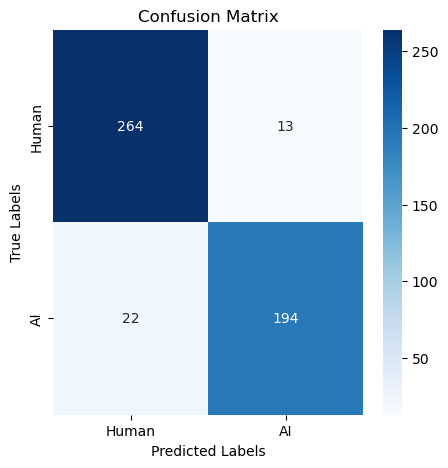

In [108]:
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [128]:
torch.save(pretrained_tinybert, "pretrained_tinybert.pth")

print("Full model saved successfully!")


Full model saved successfully!
